## Linear Models for Tabular Data

Count and Tf-IDF vectorizers were used to locally vectorize post data and and mapped to transitions in the following 3, 5, and 10. This data has been uploaded to the s3 bucket. In this notebook, we'll fit linear models to the vectorized data and compare these with the set of benchmarks as well as the LSTM performance.

The following cells import data manipulation libraries and load the data from s3. 

In [1]:
# Set the session and role and connect to s3.
import sagemaker
import boto3
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# name of S3 bucket and directory of data contained
bucket = 'sagemaker-us-east-1-539912551364'
prefix = 'retail_trading'

# connect to S3
conn = boto3.client('s3')

In [2]:
# Load the transition mappings from s3 and name posts
import pandas as pd
import numpy as np
import os

# Read transition mappings using dictionary comprehension
transition_mappings = {
    days: pd.read_csv(
        conn.get_object(Bucket=bucket, Key='transition_map_lag_{}.csv'.format(days))['Body'],
        index_col=0
    )
    for days in [3, 5, 10]
}

# Read vectorized features using dictionary comprehensions
vectorized_feature_names = [
    'count_word',
    'count_bigram',
    'tfidf_word',
    'tfidf_bigram'
]

### Define Training Functions

The vectorized files are very large and we can't easily hold all of them in memory. These files are mostly zeros and it would be possible to compress them, however, we'll avoid that by defining all of the steps required to send the data to the model training job and deal with each vectorization method transition lag separately. 

The procedure to get the data from s3 to the training job has been broken down into easily testable functions in the cells below.

In [3]:
def load_vectorized_df(filename):
    # removes any rows in a vectorized dataframe for which none of the bag of words
    # is represented
    df = pd.read_csv(conn.get_object(Bucket=bucket, Key=filename)['Body'],
                     index_col=0
                    )
    return df

# train_df = load_vectorized_df('{0:s}_train_X.csv'.format(vectorized_feature_names[0]))
# train_df.head()

In [4]:
def split_xy(vec_df, transition_mapping):
    comb_df = (
        pd.merge(vec_df, 
                 transition_mapping,
                 how='inner',
                 on='text_hash')
        .drop(columns=['text_hash'])
        .sample(frac=1)
        .dropna()
    )
    return comb_df.drop(columns = ['TransitionAfterLag']), comb_df['TransitionAfterLag']
# train_X_3, train_y_3 = split_xy(train_df, transition_mappings[3])
# train_X_3.head(3)

In [22]:
# import LinearLearner
from sagemaker import LinearLearner
from sagemaker.serializers import NumpySerializer

def train_linear_clf(train_X,
                     train_y, 
                     hyperparameters = {'instance_count': 1,
                                        'instance_type': 'ml.c4.xlarge',
                                        'predictor_type': 'binary_classifier',
                                        'use_bias': True}):
    

    # instantiate LinearLearner
    linear_clf = LinearLearner(role=role,
                               **hyperparameters)
    formatted_train_data = linear_clf.record_set(train=train_X.values.astype(np.float32), 
                                                 labels=train_y.values.astype(np.float32))
    linear_clf.fit(formatted_train_data)
    return linear_clf

bucket_name = sagemaker_session.default_bucket()
prefix = 'retail-trading-tabular'
output_path='s3://{}/{}/'.format(bucket_name, prefix)

hyperparameters = {
    'instance_count': 1,
    'instance_type': 'ml.c4.xlarge',
    'predictor_type': 'binary_classifier',
    'use_bias': True,
    'output_path': output_path,
    'epochs': 15,
    'binary_classifier_model_selection_criteria': 'precision_at_target_recall',
    'target_recall': 0.25
}

# linear_clf = train_linear_clf(train_X_3, train_y_3, hyperparameters)
# del train_df
# del train_X_3
# del train_y_3

In [23]:
from sagemaker import LinearLearnerModel
import matplotlib.pyplot as plt
from sklearn.metrics import  roc_curve, RocCurveDisplay, roc_auc_score
%matplotlib inline

def evaluate(predictor, test_features, test_labels, verbose=True):
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    test_probs = np.concatenate([np.array([x.label['score'].float32_tensor.values[0] for x in batch])
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        
        fpr, tpr, _ = roc_curve(test_labels, test_probs, pos_label=1)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
        print('ROC AUC Score: {0:}'.format(roc_auc_score(test_labels, test_probs)))
    
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

def deploy(model, test_X, test_y, delete_endpoint=True):
    
    if type(model) is str:
        model = LinearLearnerModel(model_data = model,
                                   role = role)
    
    predictor = model.deploy(initial_instance_count=1,
                             instance_type = 'ml.t2.medium')
    
    return predictor


In [24]:
train_df = load_vectorized_df('{0:s}_train_X.csv'.format(vectorized_feature_names[0]))
train_X_3, train_y_3 = split_xy(train_df, transition_mappings[3])
linear_clf = train_linear_clf(train_X_3, train_y_3, hyperparameters)
del train_df
del train_X_3
del train_y_3

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-10-28 22:39:16 Starting - Starting the training job...
2021-10-28 22:39:39 Starting - Launching requested ML instancesProfilerReport-1635460755: InProgress
......
2021-10-28 22:40:40 Starting - Preparing the instances for training............
2021-10-28 22:42:47 Downloading - Downloading input data...
2021-10-28 22:43:00 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/28/2021 22:43:26 INFO 139685833357120] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


--------------!prediction (col)   0.0  1.0
actual (row)               
0.0               6631  171
1.0                 28    0

Recall:     0.000
Precision:  0.000
Accuracy:   0.971
ROC AUC Score: 0.5407101902801696


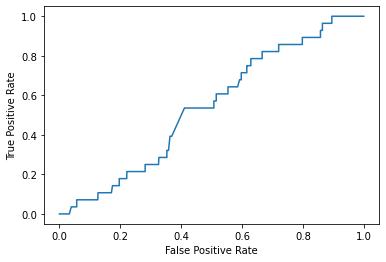

In [25]:
test_df = load_vectorized_df('{0:s}_test_X.csv'.format(vectorized_feature_names[0]))
test_X_3, test_y_3 = split_xy(test_df, transition_mappings[3])

predictor = deploy(linear_clf, 
                   test_X_3.values.astype(np.float32), 
                   test_y_3.values.astype(np.float32))
results = evaluate(predictor, 
                   test_X_3.values.astype(np.float32), 
                   test_y_3.values.astype(np.float32), 
                   verbose=True)
predictor.delete_endpoint()

In [10]:
train_df = load_vectorized_df('{0:s}_train_X.csv'.format(vectorized_feature_names[0]))
train_X_5, train_y_5 = split_xy(train_df, transition_mappings[5])
linear_clf = train_linear_clf(train_X_5, train_y_5, hyperparameters)
del train_df
del train_X_5
del train_y_5

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-10-28 22:00:12 Starting - Starting the training job...
2021-10-28 22:00:36 Starting - Launching requested ML instancesProfilerReport-1635458411: InProgress
......
2021-10-28 22:01:37 Starting - Preparing the instances for training............
2021-10-28 22:03:37 Downloading - Downloading input data...
2021-10-28 22:04:04 Training - Downloading the training image...
2021-10-28 22:04:37 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/28/2021 22:04:32 INFO 139967384917824] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_meth

prediction (col)   0.0   1.0
actual (row)                
0.0               3435  3367
1.0                 14    14

Recall:     0.500
Precision:  0.004
Accuracy:   0.505
ROC AUC Score: 0.4902654681396228


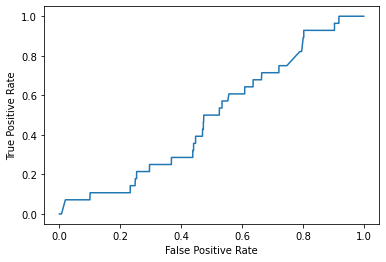

In [13]:
test_df = load_vectorized_df('{0:s}_test_X.csv'.format(vectorized_feature_names[0]))
test_X_5, test_y_5 = split_xy(test_df, transition_mappings[5])

predictor = deploy(linear_clf, 
                   test_X_5.values.astype(np.float32),                             
                   test_y_5.values.astype(np.float32))
results = evaluate(predictor, 
                   test_X_5.values.astype(np.float32),
                   test_y_5.values.astype(np.float32),
                   verbose=True)
predictor.delete_endpoint()

In [14]:
train_df = load_vectorized_df('{0:s}_train_X.csv'.format(vectorized_feature_names[0]))
train_X_10, train_y_10 = split_xy(train_df, transition_mappings[10])
linear_clf = train_linear_clf(train_X_10, train_y_10, hyperparameters)
del train_df
del train_X_10
del train_y_10

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-09-07 02:59:28 Starting - Starting the training job...
2021-09-07 02:59:52 Starting - Launching requested ML instancesProfilerReport-1630983567: InProgress
......
2021-09-07 03:00:52 Starting - Preparing the instances for training.........
2021-09-07 03:02:26 Downloading - Downloading input data......
2021-09-07 03:03:13 Training - Downloading the training image.Docker entrypoint called with argument(s): train
Running default environment configuration script
[09/07/2021 03:03:28 INFO 140697216255808] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer

In [ ]:
test_df = load_vectorized_df('{0:s}_test_X.csv'.format(vectorized_feature_names[0]))
test_X_10, test_y_10 = split_xy(test_df, transition_mappings[10])

predictor = deploy(linear_clf, 
                   test_X_10.values.astype(np.float32), 
                   test_y_10.values.astype(np.float32))
results = evaluate(predictor, 
                   test_X_10.values.astype(np.float32),
                   test_y_10.values.astype(np.float32),
                   verbose=True)
predictor.delete_endpoint()

In [10]:
def evaluate_features_lm(vectorized_feature_name, lag, hyperparameters):
    
    # Load the train data from s3 bucket
    train_df = load_vectorized_df('{0:s}_train_X.csv'.format(vectorized_feature_name))
    train_X, train_y = split_xy(train_df, transition_mappings[lag])
    
    # train linear classifier, delete train_X, train_y to free up memory
    linear_clf = train_linear_clf(train_X, train_y, hyperparameters)
    del train_X, train_y
    
    # load test data from s3 bucket
    test_df = load_vectorized_df('{0:s}_test_X.csv'.format(vectorized_feature_name))
    test_X, test_y = split_xy(test_df, transition_mappings[lag])
    
    # deploy and evaluate endpoint
    predictor, metrics = deploy_and_test(linear_clf, 
                                         test_X.values.astype(np.float32), 
                                         test_y.values.astype(np.float32))
    delete_endpoint(predictor)
    return metrics



In [14]:
count_bigram_3_metrics = evaluate_features_lm(vectorized_feature_names[1], 3, hyperparameters)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-07-14 22:27:45 Starting - Starting the training job...
2021-07-14 22:28:09 Starting - Launching requested ML instancesProfilerReport-1626301665: InProgress
......
2021-07-14 22:29:09 Starting - Preparing the instances for training............
2021-07-14 22:31:11 Downloading - Downloading input data
2021-07-14 22:31:11 Training - Downloading the training image...
2021-07-14 22:31:32 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/14/2021 22:31:37 INFO 140399268001600] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method'

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------------!

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


prediction (col)   0.0  1.0
actual (row)               
0.0               5882  920
1.0                 24    4

Recall:     0.143
Precision:  0.004
Accuracy:   0.862

Deleted linear-learner-2021-07-14-22-32-29-655


In [11]:
tfidf_word_3_metrics = evaluate_features_lm(vectorized_feature_names[2], 3, hyperparameters)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-07-15 20:44:09 Starting - Starting the training job...
2021-07-15 20:44:31 Starting - Launching requested ML instancesProfilerReport-1626381848: InProgress
...
2021-07-15 20:45:09 Starting - Preparing the instances for training............
2021-07-15 20:47:03 Downloading - Downloading input data...
2021-07-15 20:47:32 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[07/15/2021 20:47:50 INFO 140637317904192] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer':

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


-----------------------!

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


prediction (col)   0.0  1.0
actual (row)               
0.0               6780   22
1.0                 27    1

Recall:     0.036
Precision:  0.043
Accuracy:   0.993

Deleted linear-learner-2021-07-15-20-48-53-878


In [24]:
from sagemaker.predictor import Predictor
from sagemaker.serializers import NumpySerializer

predictor = Predictor(endpoint_name='linear-learner-2021-07-13-23-20-23-318',
                      sagemaker = sagemaker_session,
                      serializer = NumpySerializer())

In [ ]:
from sagemaker import 